# SPAN Benchmarks H3K4me3 vs RNA-seq

See https://pubmed.ncbi.nlm.nih.gov/27169896/


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Hg38 load peaks

In [3]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me3']
GSE26320_REPS = ['rep1', 'rep2']

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = 'rep1' if 'rep1' in f else 'rep2'
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [5]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['file'] = [f'{GSE26320_PATH_HG38}/macs2/{f}' for f in df_fdr_macs2['file']]
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['file'] = [f'{GSE26320_PATH_HG38}/macs2/{f}' for f in df_fdr_macs2broad['file']]
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['file'] = [f'{GSE26320_PATH_HG38}/sicer/{f}' for f in df_fdr_sicer['file']]
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['file'] = [f'{GSE26320_PATH_HG38}/span/{f}' for f in df_fdr_span['file']]
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/536 [00:00<?, ?it/s]

MACS2 16


  0%|          | 0/536 [00:00<?, ?it/s]

MACS2 broad 16


  0%|          | 0/67 [00:00<?, ?it/s]

SICER 16


  0%|          | 0/36 [00:00<?, ?it/s]

SPAN 16


,file,modification,cell,replicate,fdr,peaks,avlength,tool
2,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K4me3,HepG2,rep2,0.05,36677,1662.523761,SPAN
2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,HSMM,rep1,0.05,25114,1075.123397,MACS2
15,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,NHEK,rep2,0.01,29035,2729.415016,SICER
0,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,HMEC,rep1,0.01,25543,2407.190111,SICER
9,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me3,GM12878,rep2,0.01,31862,3477.362940,SICER


In [6]:
# TOOLS_PALETTE = {'MACS2': 'blue', 'MACS2 broad': 'orange', 'SICER': 'green', 'SPAN': 'red', 'Genes': 'brown'}
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

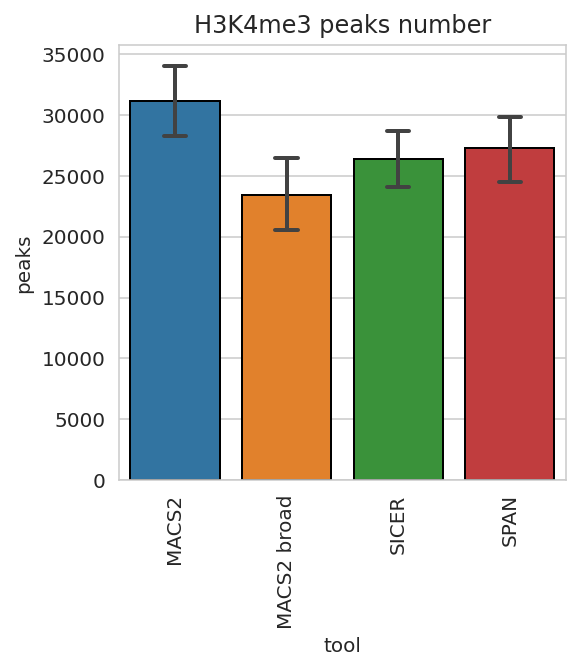

In [7]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me3 peaks number')
plt.show()

In [8]:
print('Load lengths')
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,tool,length
75568,MACS2,326
497886,SPAN,2096
431602,SICER,5599
299375,MACS2 broad,891
102069,MACS2,294
260037,MACS2 broad,2687
257827,MACS2 broad,6364
601854,SPAN,517
499511,SPAN,496
600745,SPAN,1161


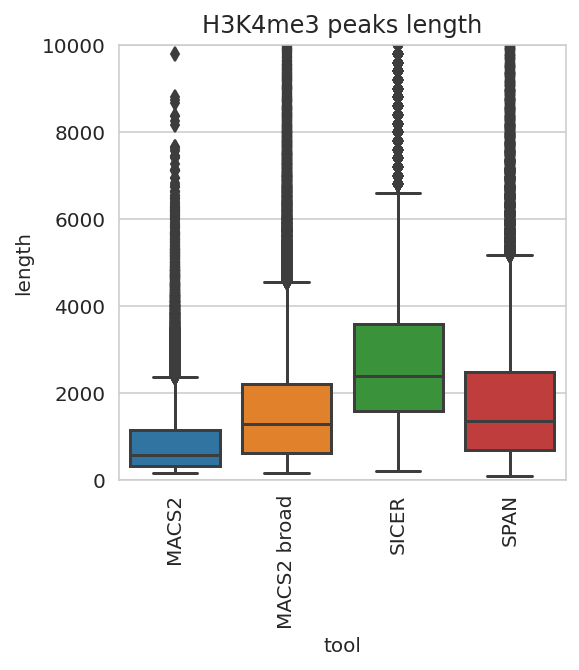

In [9]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax)
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 10_000])
plt.show()

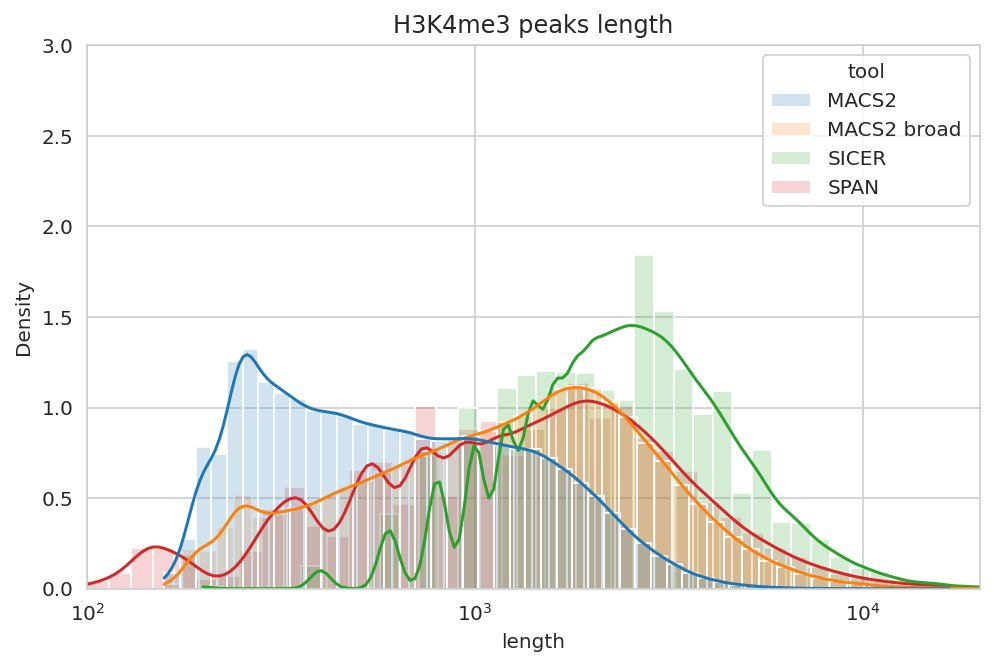

In [10]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

In [11]:
# Randomly tweak SPAN,SICER lengths for visualization purposes
tspan = t['tool'] == 'SPAN'
t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))
tsicer = t['tool'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


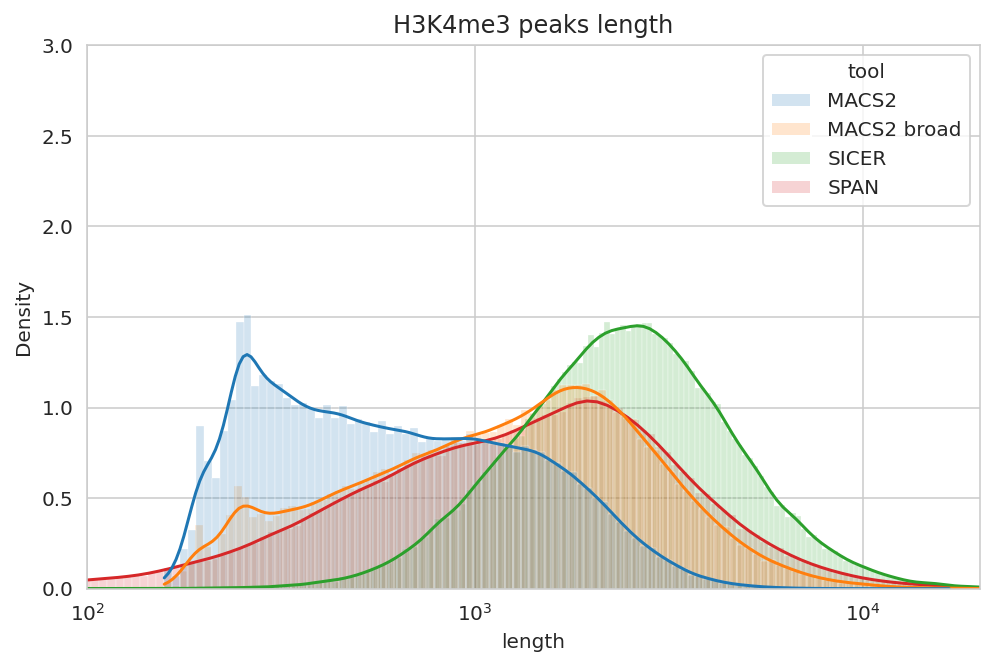

In [12]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('H3K4me3 peaks length')
plt.show()

## Consistency analysis between replicates

In [15]:
import tempfile
from itertools import product

reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(5)

0it [00:00, ?it/s]

GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3


,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len
12,H3K4me3,K562,MACS2,rep1,rep2,37693,29808188,32386,28239409,28115,22750849,26236,22750849
26,H3K4me3,Huvec,SICER,rep1,rep2,24595,74793205,21074,59212726,17873,47145251,17957,47145251
8,H3K4me3,HSMM,MACS2,rep1,rep2,25114,27000649,26046,24723059,20082,21604986,21934,21604986
6,H3K4me3,HMEC,SICER,rep1,rep2,25543,61486857,14360,47447640,13724,37629612,13874,37629612
16,H3K4me3,NHEK,MACS2,rep1,rep2,38852,31458600,39586,30256860,26351,22540409,29496,22540409


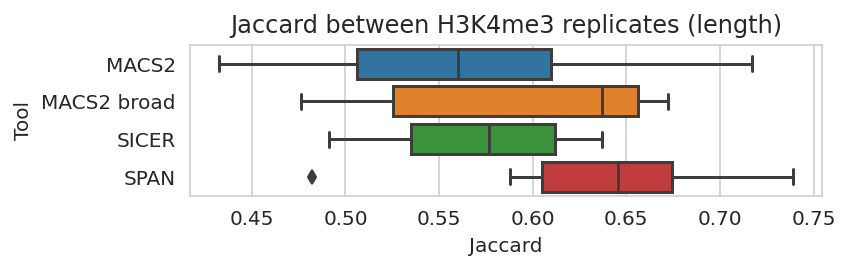

In [16]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))

g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard', palette=TOOLS_PALETTE)
ax = g_result.axes
ax.set_title('Jaccard between H3K4me3 replicates (length)')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')


plt.tight_layout()
plt.show()

In [17]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]
reps_overlap.sample(5)

,modification,cell,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks1_overlap_len,peaks2_overlap,peaks2_overlap_len,jaccard,peak1_overlap_fraction,peak2_overlap_fraction,peak1_overlap_fraction_len,peak2_overlap_fraction_len
6,H3K4me3,HMEC,SICER,rep1,rep2,25543,61486857,14360,47447640,13724,37629612,13874,37629612,0.527728,0.537290,0.966156,0.611994,0.793077
0,H3K4me3,GM12878,MACS2,rep1,rep2,41149,29831660,38141,33961060,30841,22301464,26627,22301464,0.537498,0.749496,0.698120,0.747577,0.656678
17,H3K4me3,NHEK,MACS2 broad,rep1,rep2,40028,62002403,27886,42087690,22675,35185217,23454,35185217,0.510635,0.566478,0.841067,0.567482,0.835998
1,H3K4me3,GM12878,MACS2 broad,rep1,rep2,29024,58752715,27319,57626660,22221,45294289,22039,45294289,0.637184,0.765608,0.806728,0.770931,0.785995
4,H3K4me3,HMEC,MACS2,rep1,rep2,26661,21349997,24894,19214737,19303,14560292,20868,14560292,0.559916,0.724016,0.838274,0.681981,0.757767


In [18]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

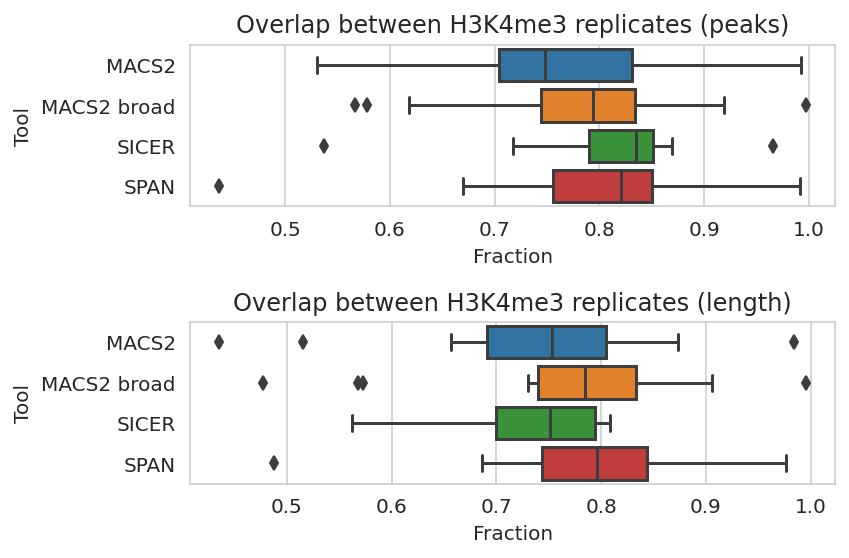

In [19]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0], palette=TOOLS_PALETTE)
ax = g_result.axes
ax.set_title('Overlap between H3K4me3 replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1], palette=TOOLS_PALETTE)
ax = g_result.axes
ax.set_title('Overlap between H3K4me3 replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

# H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

## Load hg38 gtf

In [20]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

,chromosome,db,type,start,end,point1,strand,point2,aux
2177842,chr13,HAVANA,UTR,26401466,26401624,.,+,.,"gene_id ""ENSG00000132964.13""; transcript_id ""E..."
2322367,chr14,HAVANA,exon,95140659,95140759,.,-,.,"gene_id ""ENSG00000100697.17""; transcript_id ""E..."
1076848,chr5,HAVANA,exon,179706258,179706331,.,+,.,"gene_id ""ENSG00000127022.16""; transcript_id ""E..."
2545722,chr16,HAVANA,exon,35247024,35247095,.,-,.,"gene_id ""ENSG00000259897.2""; transcript_id ""EN..."
354067,chr2,HAVANA,exon,38591530,38591641,.,-,.,"gene_id ""ENSG00000143889.16""; transcript_id ""E..."
332488,chr2,HAVANA,exon,23765506,23765628,.,-,.,"gene_id ""ENSG00000119778.15""; transcript_id ""E..."
1158833,chr6,HAVANA,exon,72390598,72390885,.,+,.,"gene_id ""ENSG00000079841.20""; transcript_id ""E..."
2471325,chr16,HAVANA,exon,491134,491268,.,+,.,"gene_id ""ENSG00000090565.17""; transcript_id ""E..."
2461984,chr15,HAVANA,CDS,92929030,92929091,.,+,0,"gene_id ""ENSG00000173575.23""; transcript_id ""E..."
551328,chr2,HAVANA,start_codon,231206239,231206241,.,+,0,"gene_id ""ENSG00000135931.19""; transcript_id ""E..."


In [21]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [22]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


,chromosome,db,type,start,end,point1,strand,point2,gene_id,gene_type,gene_name,level
2202899,chr13,ENSEMBL,gene,60034465,60034762,.,-,.,ENSG00000265745,misc_RNA,RN7SL375P,3
179591,chr1,HAVANA,gene,147608331,147610187,.,+,.,ENSG00000289419,lncRNA,ENSG00000289419,2
2455740,chr15,HAVANA,gene,89400173,89401723,.,+,.,ENSG00000289128,lncRNA,ENSG00000289128,2
978778,chr5,HAVANA,gene,76403285,76708132,.,+,.,ENSG00000145703,protein_coding,IQGAP2,1
607840,chr3,HAVANA,gene,32151083,32151895,.,-,.,ENSG00000236732,unprocessed_pseudogene,ENSG00000236732,1


## Annotate quanitified RNA-seq with TSS positions

In [23]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv


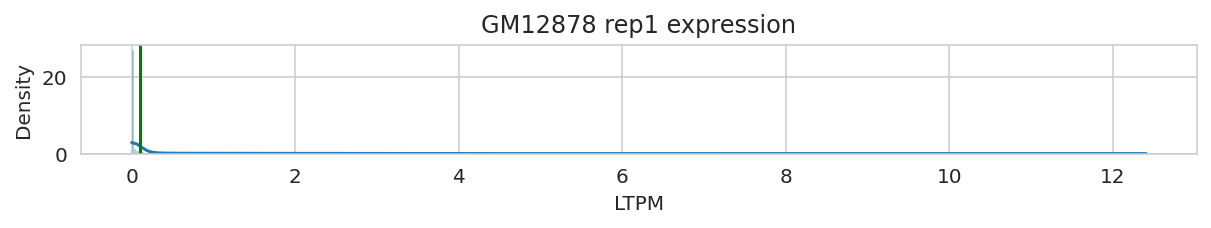

Total genes with positions 58387
Genes logTPM > 0.1 15835
Merging overlapping regions 15835
Reduced to 13836
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1_tss500.bed
GM12878 rep2 GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv


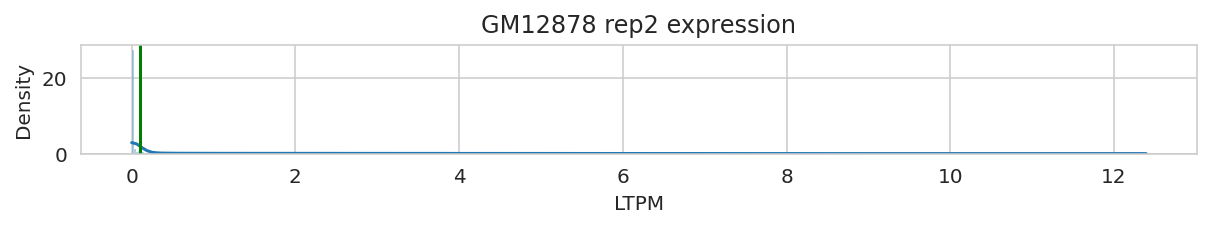

Total genes with positions 56646
Genes logTPM > 0.1 15750
Merging overlapping regions 15750
Reduced to 13803
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1_tss500.bed
H1 rep1 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv


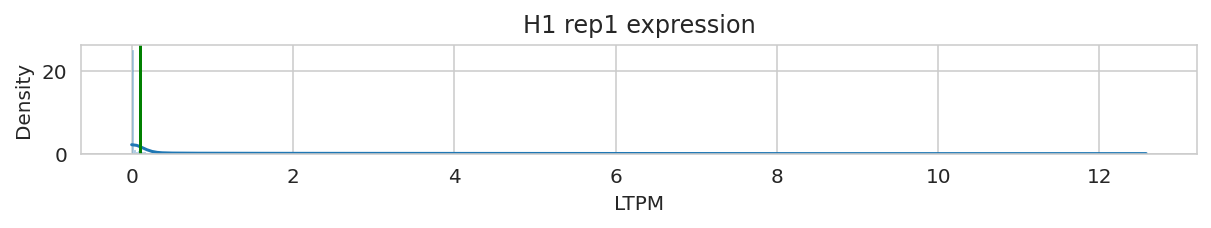

Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions 19379
Reduced to 17085
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1_tss500.bed
H1 rep2 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv


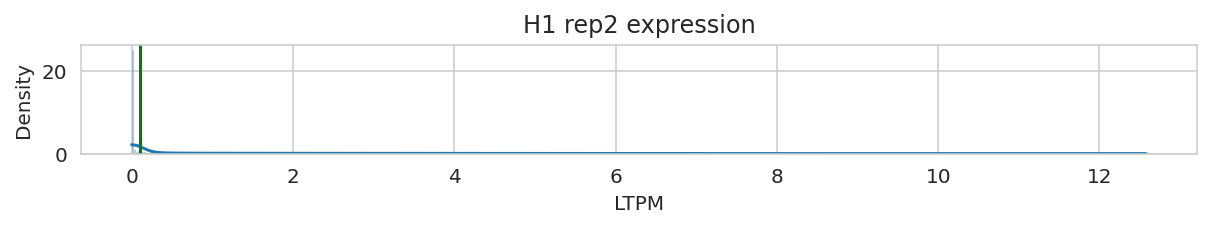

Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions 19379
Reduced to 17085
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1_tss500.bed
HMEC rep1 HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv


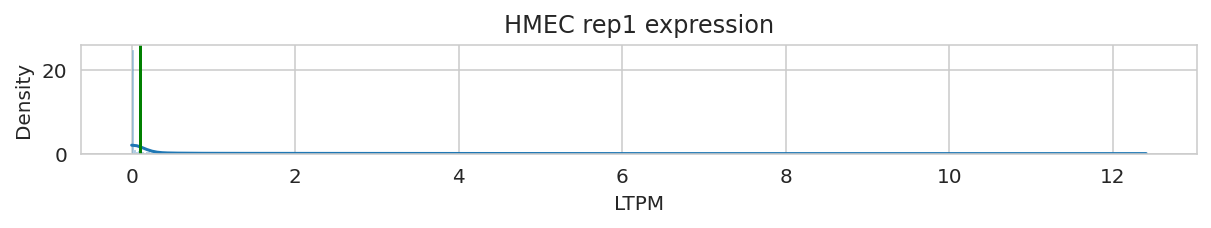

Total genes with positions 58387
Genes logTPM > 0.1 20029
Merging overlapping regions 20029
Reduced to 17476
Saved expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep1_RNAseq_hg38_ENCFF292FVY_tpm0.1_tss500.bed
HMEC rep2 HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv


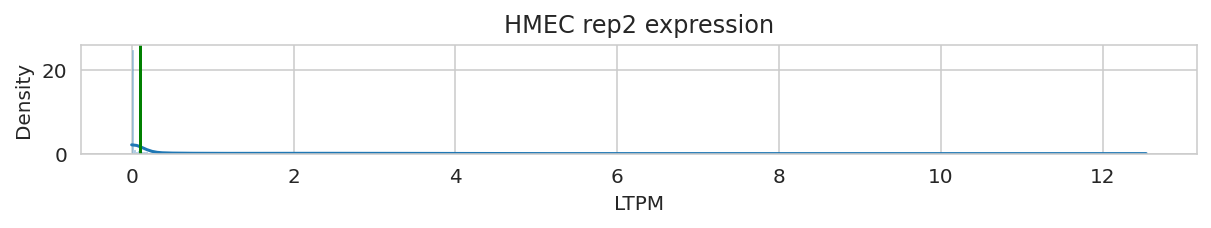

Total genes with positions 58387
Genes logTPM > 0.1 19373
Merging overlapping regions 19373
Reduced to 16935
Saved expressed genes fom HMEC to /home/jetbrains/data/2023_GSE26320_rnaseq/HMEC_rep2_RNAseq_hg38_ENCFF219EZH_tpm0.1_tss500.bed
HSMM rep1 HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv


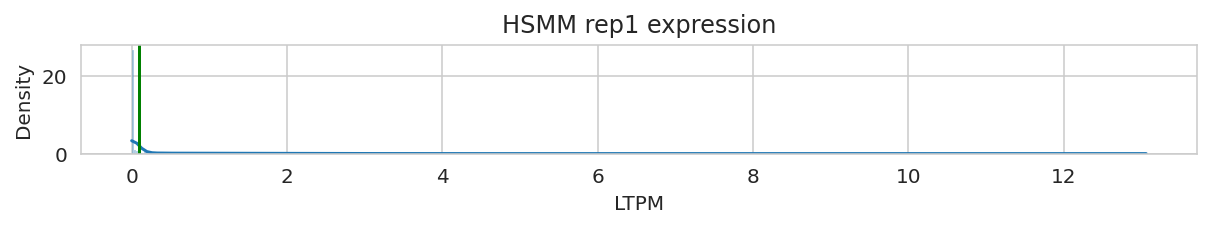

Total genes with positions 52065
Genes logTPM > 0.1 14527
Merging overlapping regions 14527
Reduced to 12943
Saved expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep1_RNAseq_hg38_ENCFF551YKI_tpm0.1_tss500.bed
HSMM rep2 HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv


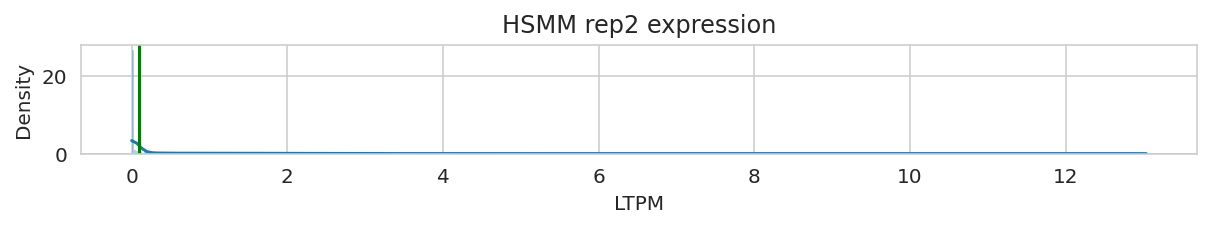

Total genes with positions 52065
Genes logTPM > 0.1 14501
Merging overlapping regions 14501
Reduced to 12942
Saved expressed genes fom HSMM to /home/jetbrains/data/2023_GSE26320_rnaseq/HSMM_rep2_RNAseq_hg38_ENCFF497BUG_tpm0.1_tss500.bed
HepG2 rep1 HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv


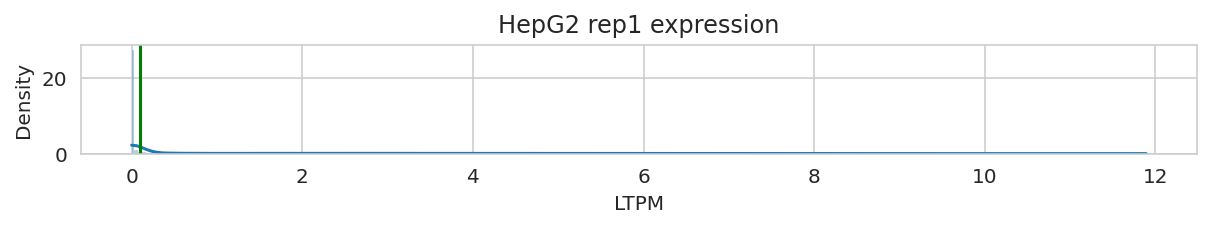

Total genes with positions 56646
Genes logTPM > 0.1 17858
Merging overlapping regions 17858
Reduced to 15531
Saved expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep1_RNAseq_hg38_ENCFF773JNC_tpm0.1_tss500.bed
HepG2 rep2 HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv


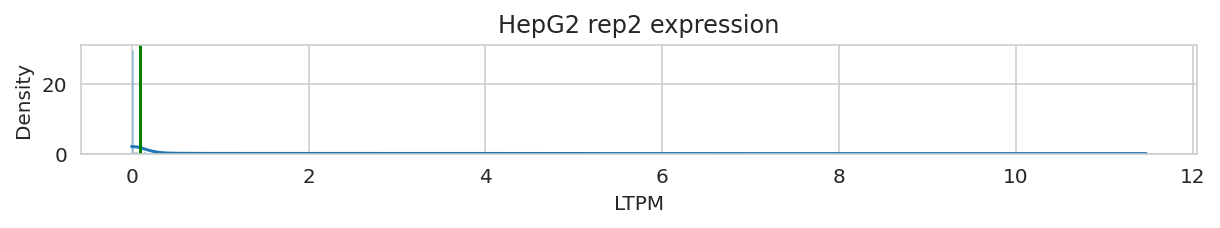

Total genes with positions 56646
Genes logTPM > 0.1 17175
Merging overlapping regions 17175
Reduced to 14951
Saved expressed genes fom HepG2 to /home/jetbrains/data/2023_GSE26320_rnaseq/HepG2_rep2_RNAseq_hg38_ENCFF570ZOT_tpm0.1_tss500.bed
Huvec rep1 Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv


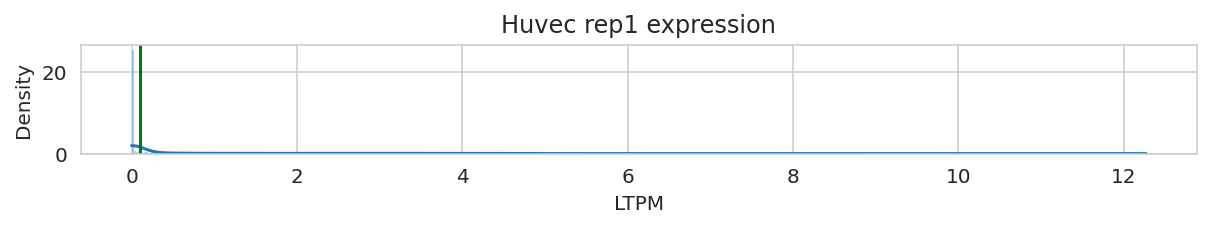

Total genes with positions 58387
Genes logTPM > 0.1 19939
Merging overlapping regions 19939
Reduced to 17448
Saved expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep1_RNAseq_hg38_ENCFF454MTF_tpm0.1_tss500.bed
Huvec rep2 Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv


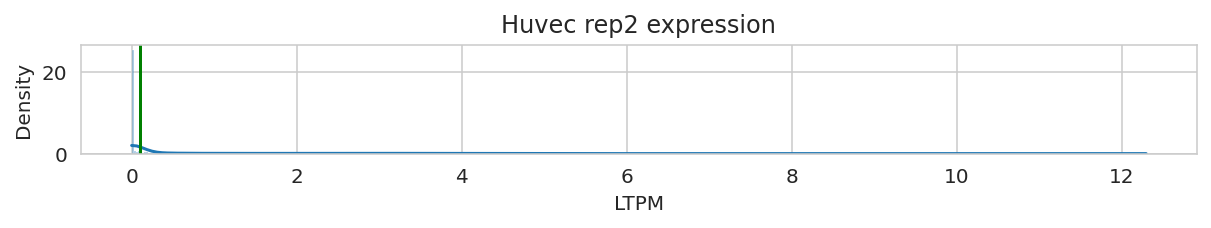

Total genes with positions 58387
Genes logTPM > 0.1 19526
Merging overlapping regions 19526
Reduced to 17037
Saved expressed genes fom Huvec to /home/jetbrains/data/2023_GSE26320_rnaseq/Huvec_rep2_RNAseq_hg38_ENCFF134FYP_tpm0.1_tss500.bed
K562 rep1 K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv


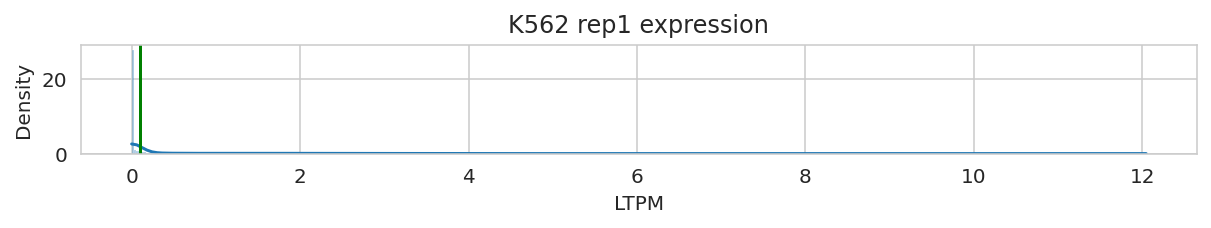

Total genes with positions 52065
Genes logTPM > 0.1 15270
Merging overlapping regions 15270
Reduced to 13424
Saved expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep1_RNAseq_hg38_ENCFF139IXQ_tpm0.1_tss500.bed
K562 rep2 K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv


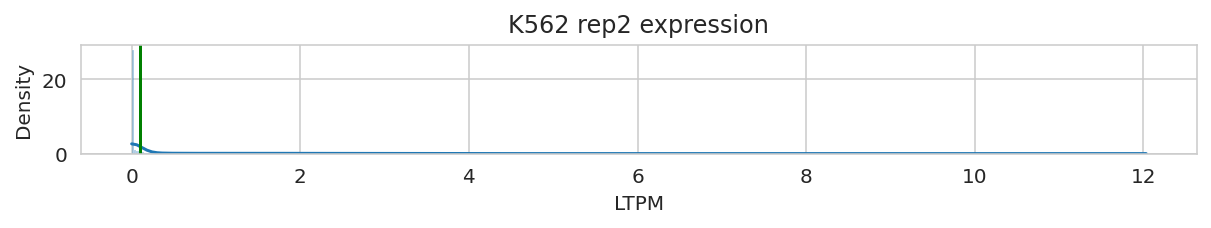

Total genes with positions 52065
Genes logTPM > 0.1 15092
Merging overlapping regions 15092
Reduced to 13267
Saved expressed genes fom K562 to /home/jetbrains/data/2023_GSE26320_rnaseq/K562_rep2_RNAseq_hg38_ENCFF088RDE_tpm0.1_tss500.bed
NHEK rep1 NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv


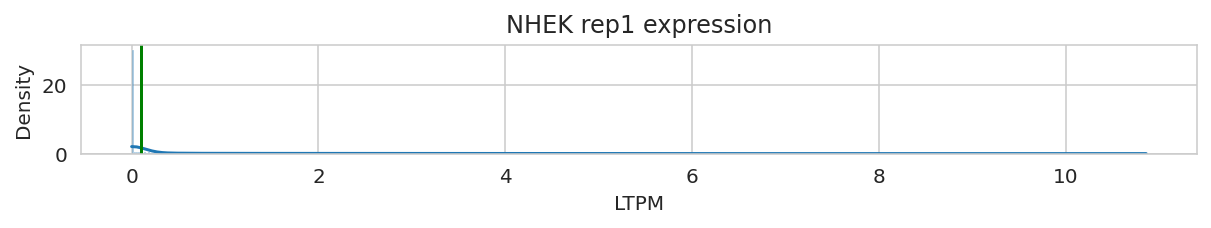

Total genes with positions 58387
Genes logTPM > 0.1 18674
Merging overlapping regions 18674
Reduced to 16615
Saved expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1_tss500.bed
NHEK rep2 NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv


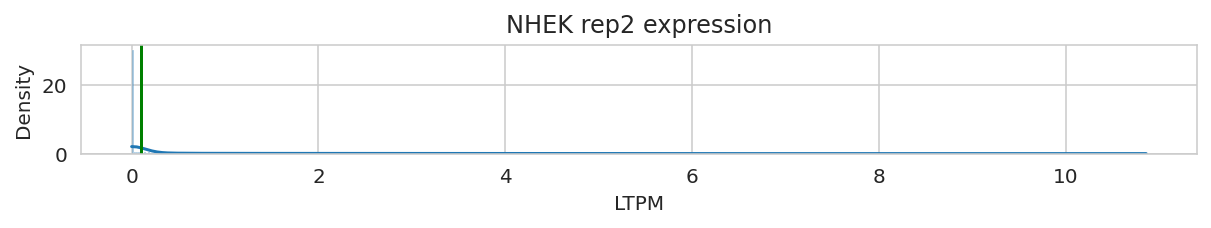

Total genes with positions 58387
Genes logTPM > 0.1 18674
Merging overlapping regions 18674
Reduced to 16615
Saved expressed genes fom NHEK to /home/jetbrains/data/2023_GSE26320_rnaseq/NHEK_rep1_RNAseq_hg38_ENCFF004JWA_tpm0.1_tss500.bed
NHLF rep1 NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv


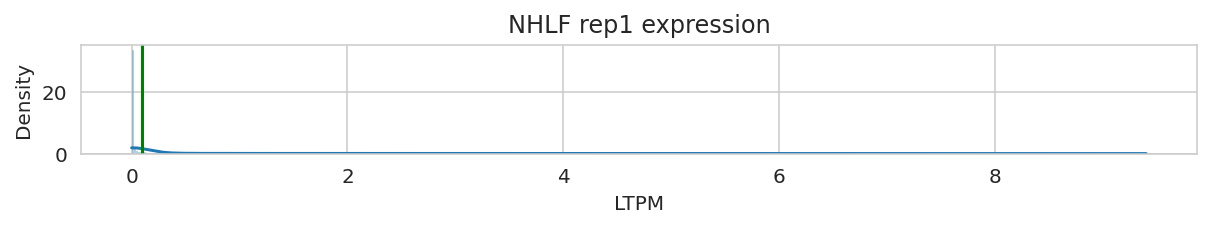

Total genes with positions 58387
Genes logTPM > 0.1 17520
Merging overlapping regions 17520
Reduced to 15261
Saved expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep1_RNAseq_hg38_ENCFF577DEC_tpm0.1_tss500.bed
NHLF rep2 NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv


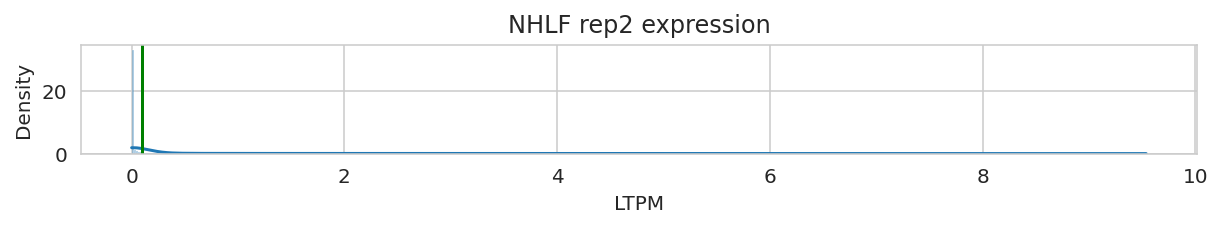

Total genes with positions 58387
Genes logTPM > 0.1 17924
Merging overlapping regions 17924
Reduced to 15634
Saved expressed genes fom NHLF to /home/jetbrains/data/2023_GSE26320_rnaseq/NHLF_rep2_RNAseq_hg38_ENCFF412KNK_tpm0.1_tss500.bed


In [24]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

EXPRESSION_TSV = {
    ('GM12878', 'rep1') : 'GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): 'GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : 'HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : 'HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : 'HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : 'HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : 'HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : 'HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : 'Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : 'Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : 'K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : 'K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : 'NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : 'NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

EXPRESSION_TSS_BED = {}
TSS = 500
THRESHOLD = 0.1

for (cell, rep), path in tqdm(EXPRESSION_TSV.items()):
    print(cell, rep, path)
    t = pd.read_csv(GSE26320_RNASEQ_PATH + '/' + path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    plt.figure(figsize=(10, 1))
    ax = plt.axes()
    g_results = sns.histplot(data=t, x='LTPM', ax=ax,
                             stat = 'density',
                             bins = 500, kde = True, alpha = 0.4)
    ax.axvline(x=THRESHOLD, color='green')
    ax.title.set_text(f'{cell} {rep} expression')
    plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    starts = [
        max(1, start - TSS if strand == '+' else end - TSS)
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    ends = [
        start + TSS if strand == '+' else end + TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    full_df['start'] = starts
    full_df['end'] = ends
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)
    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = GSE26320_RNASEQ_PATH + '/' + path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_TSS_BED[(cell, rep)] = expr_path


## Overlap H3K4me3 vs TSS expressed genes

In [25]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len', 'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len', 'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    tss_file = sorted_file(EXPRESSION_TSS_BED[c, r])
    tss = lines(tss_file)
    tss_length = int(bedl(tss_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {tss_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {tss_file} -wa -u > {tf}
        tss_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {tss_file} -wo > {tf}
        peaks_overlap_len = tss_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, r, tool, peaks, peaks_len, tss, tss_length,
                                       peaks_overlap, peaks_overlap_len, tss_overlap, tss_overlap_len)
# bench_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


In [26]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['tss_overlap'], bench_df['tss'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['tss_overlap_len'], bench_df['tss_len'])]
bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['tss_len'], bench_df['tss_overlap_len'])
]

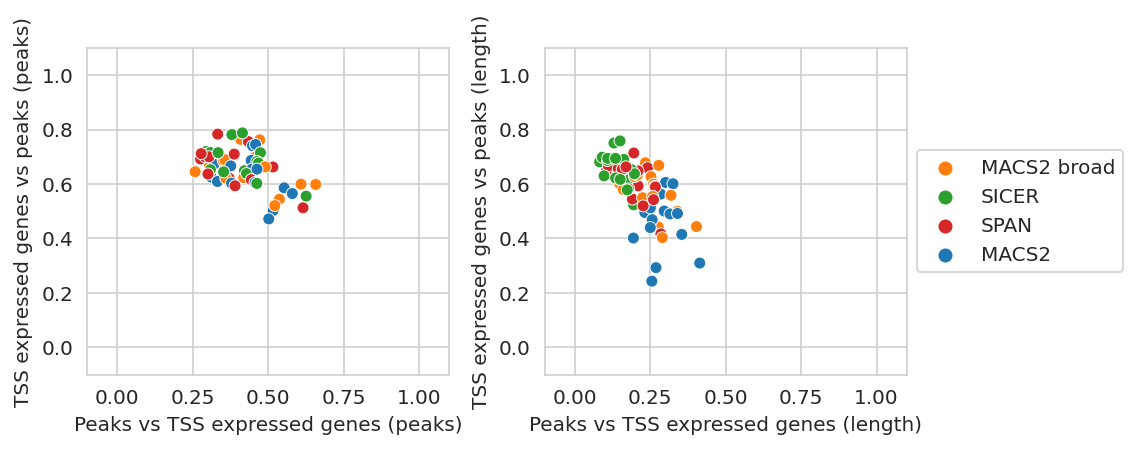

In [27]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (peaks)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (length)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [46]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
t.sort_values(by=['name'], inplace=True)
del ts

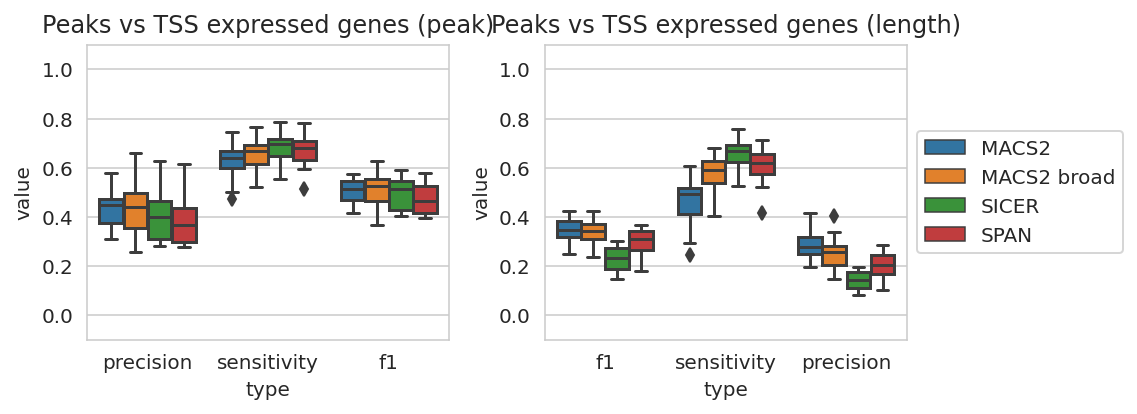

In [47]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name',
                            palette=TOOLS_PALETTE, ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs TSS expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K4me3 diff vs TSS expressed genes

In [30]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len',
             'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len',
             'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    print(c, r)
    tss_file = sorted_file(EXPRESSION_TSS_BED[(c, r)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    tss = lines(tss_file)
    tss_len = int(bedl(tss_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {tss_file} -wo > {tf2}
            peaks_overlap_len = tss_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, r, name,
                 peaks, peaks_len,
                 tss, tss_len,
                 peaks_overlap, peaks_overlap_len,
                 tss_overlap, tss_overlap_len)

display(diff_bench_df.sample())

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,name,peaks,peaks_len,tss,tss_len,peaks_overlap,peaks_overlap_len,tss_overlap,tss_overlap_len
66,H1,rep1,SPAN - MACS2,2739,1452847,17085,17755384,109,43692,110,43692


In [31]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap'], diff_bench_df['tss'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap_len'], diff_bench_df['tss_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['tss_len'], diff_bench_df['tss_overlap_len'])
]

In [32]:
full_bench_df = pd.concat([bench_df,diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

,cell,replicate,name,peaks,peaks_len,tss,tss_len,peaks_overlap,peaks_overlap_len,tss_overlap,tss_overlap_len,precision,sensitivity,f1,sensitivity_len,precision_len,f1_len,jaccard
86,HMEC,rep2,SPAN - SICER,235,91180,16935,17656948,26,3937,26,3937,0.110638,0.001535,0.003029,0.000223,0.043178,0.000444,0.000222
53,Huvec,rep1,SICER,24595,74793205,17448,18182714,10536,11217736,11135,11217736,0.428380,0.638182,0.512646,0.616945,0.149983,0.241304,0.137206
4,GM12878,rep2,MACS2 broad,27319,57626660,13803,14363322,9160,9163409,9576,9163409,0.335298,0.693762,0.452096,0.637973,0.159013,0.254575,0.145852
100,K562,rep1,SPAN - MACS2,11794,9712918,13424,13959273,266,142290,267,142290,0.022554,0.019890,0.021138,0.010193,0.014650,0.012022,0.006047
52,Huvec,rep1,MACS2 broad,24934,39103549,17448,18182714,10453,10084884,10870,10084884,0.419227,0.622994,0.501191,0.554641,0.257902,0.352087,0.213657


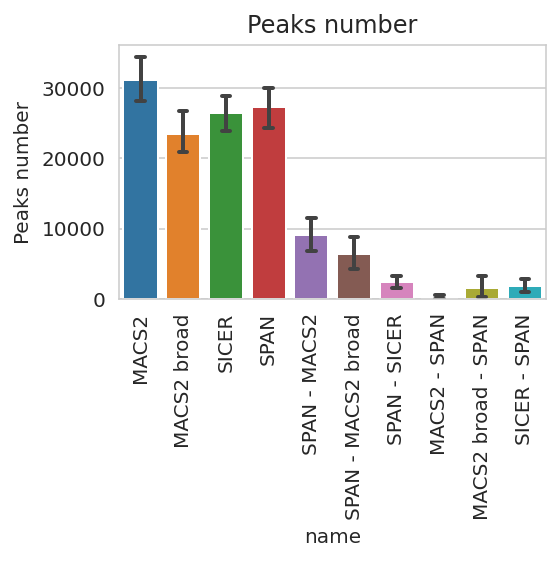

In [33]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

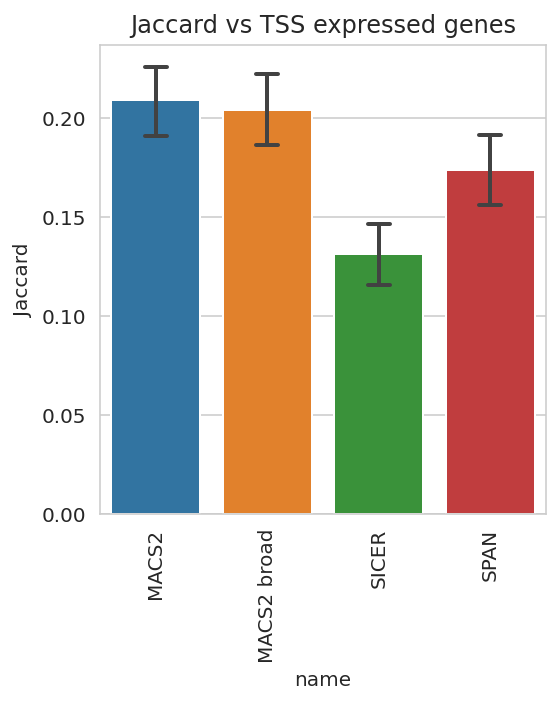

In [49]:
plt.figure(figsize=(4, 5))
ax = plt.axes()
ax.title.set_text('Jaccard vs TSS expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [51]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

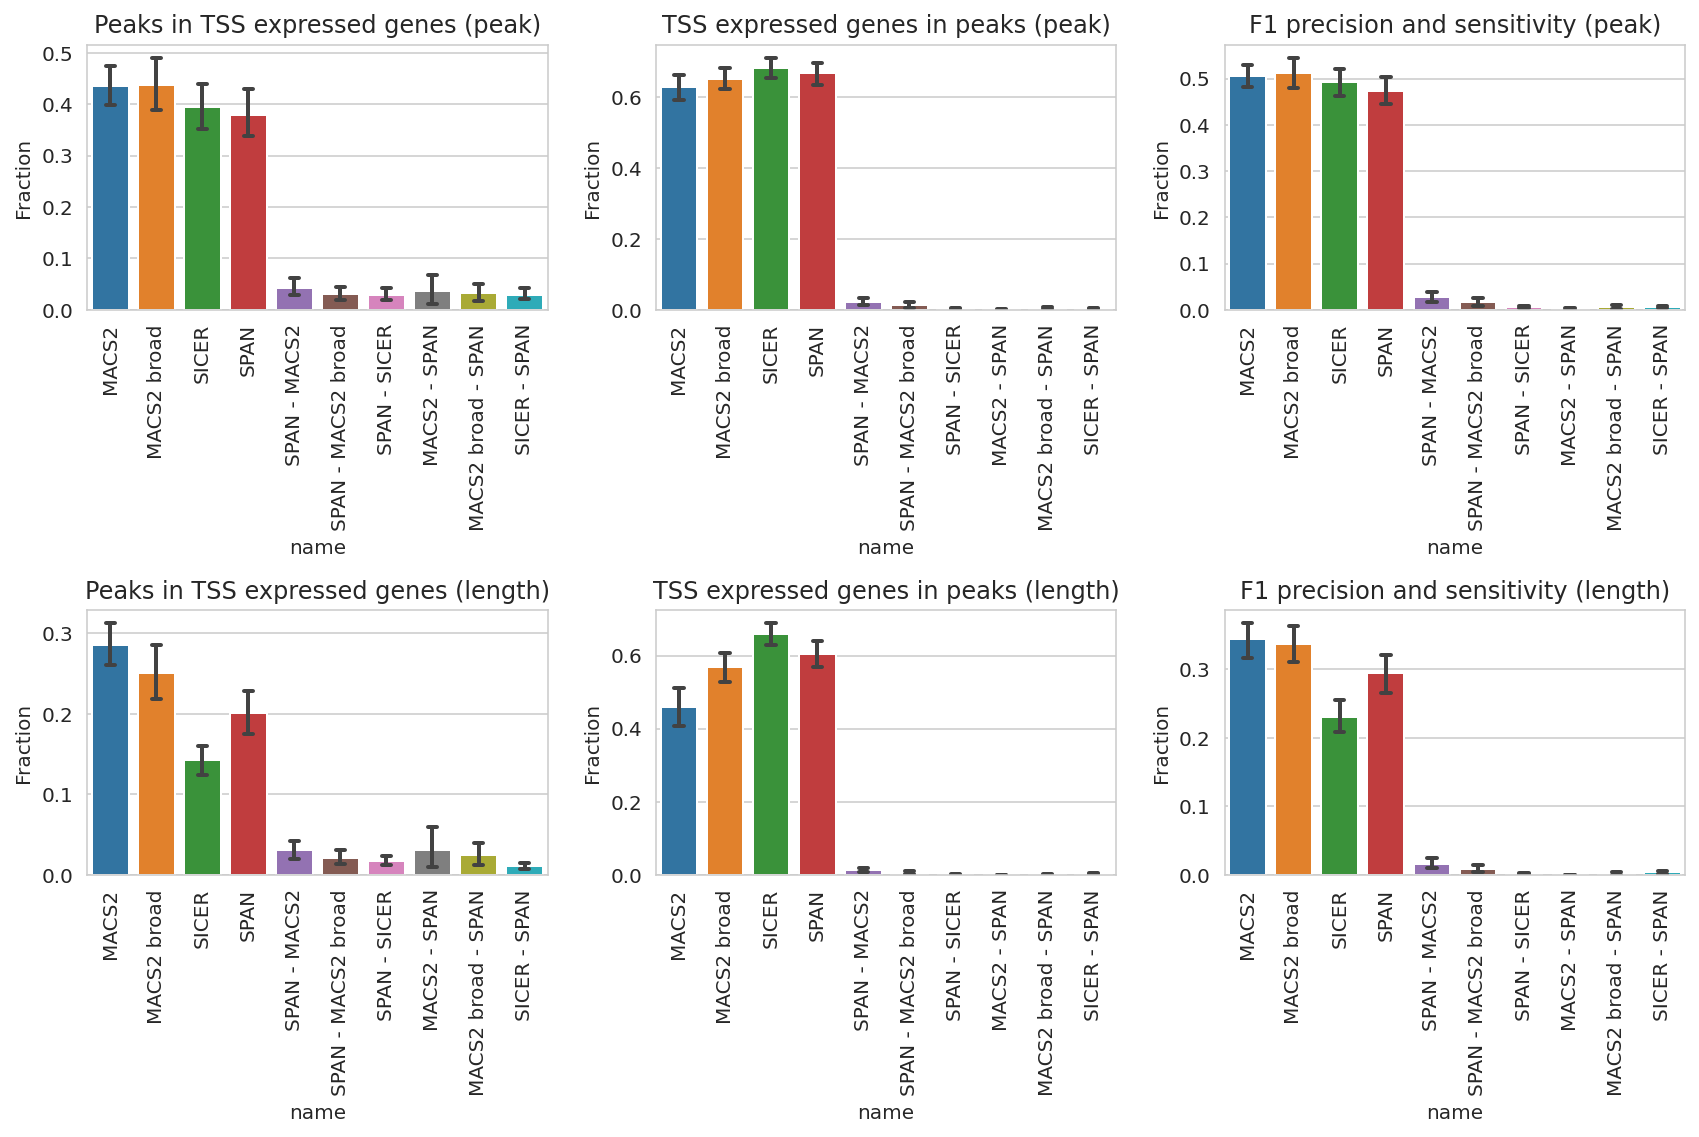

In [52]:
plt.figure(figsize=(12, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in TSS expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'TSS expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

# Venn diagram

In [37]:
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)

num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']

def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    max_overlap = max(overlap12, overlap21)
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, max_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, max_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    # venn2_circles(subsets=subsets, color='grey', ax=ax)

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            if overlap12 != 0 and overlap21 != 0:
                if overlap12 > overlap21:
                    prop = f'{overlap12 / overlap21:.1f} : 1'
                else:
                    prop = f'1 : {overlap21 / overlap12:.1f}'
                prop = prop.replace('.0', '')  # Cosmetics
            else:
                prop = ''
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(max_overlap, engineer))
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')

VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']

def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets=(v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

0it [00:00, ?it/s]

GM12878 rep1
Venn diagrams of SPAN vs other tools (peaks)


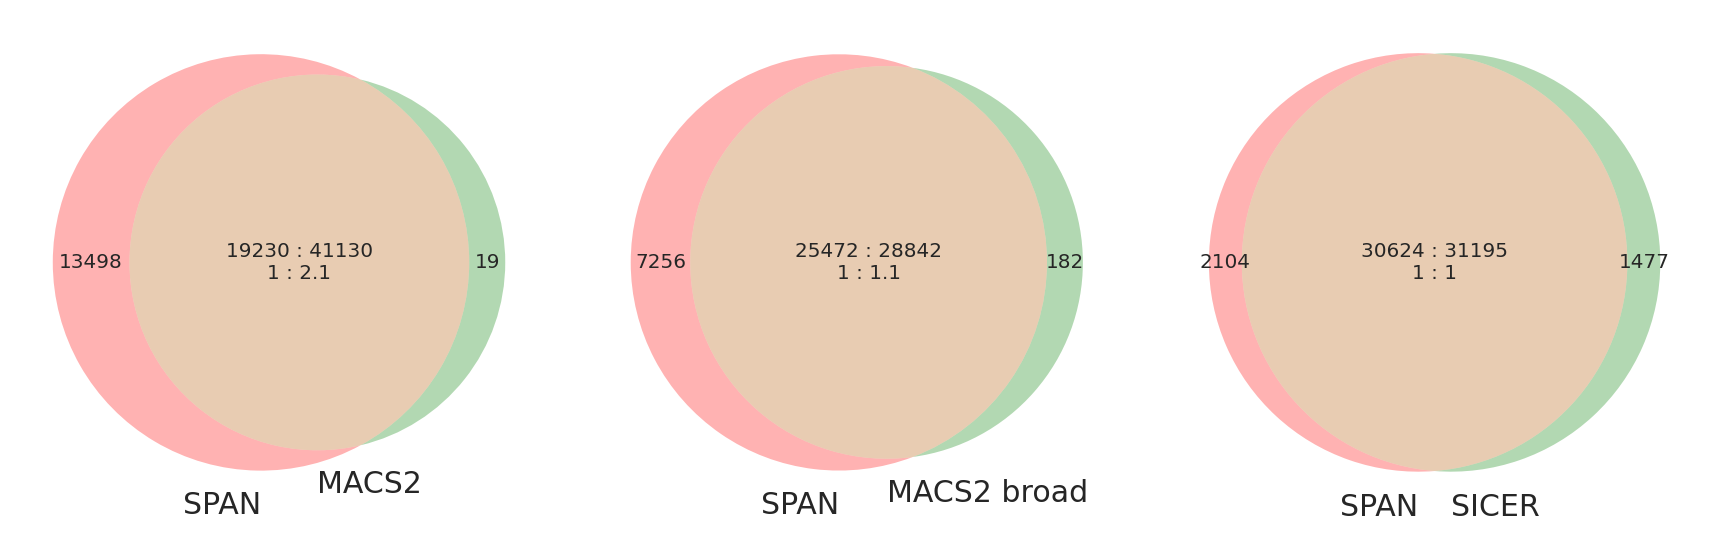

Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)


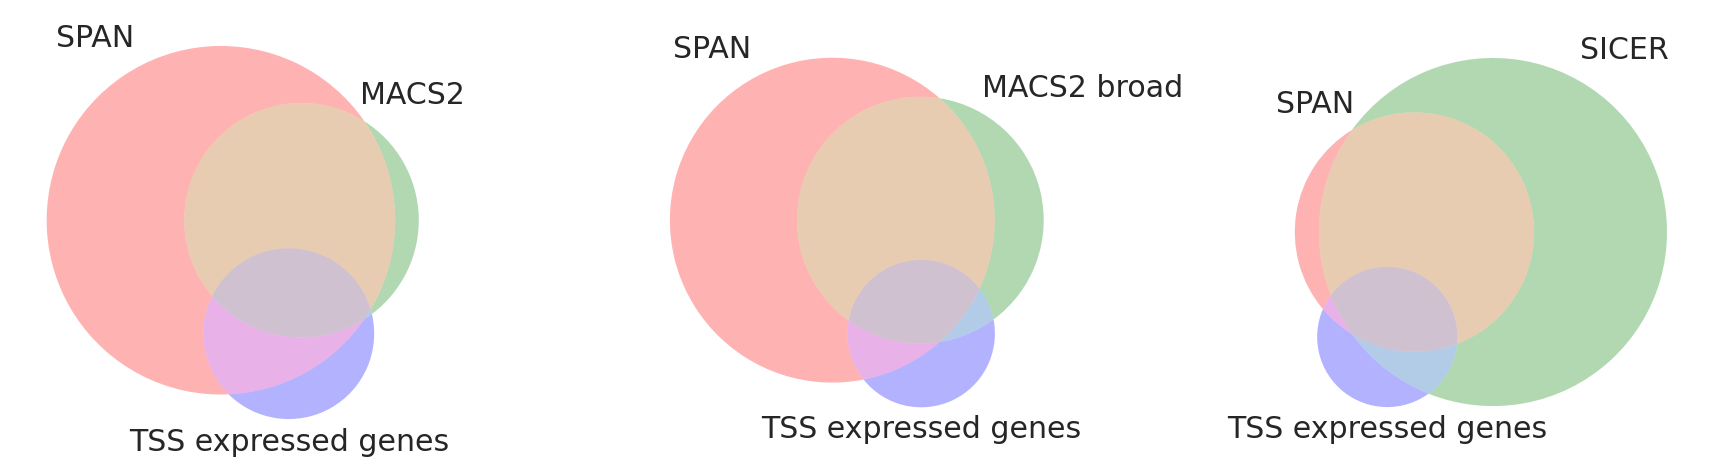

Venn diagram of SPAN vs other tools and TSS expressed genes (length)
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!


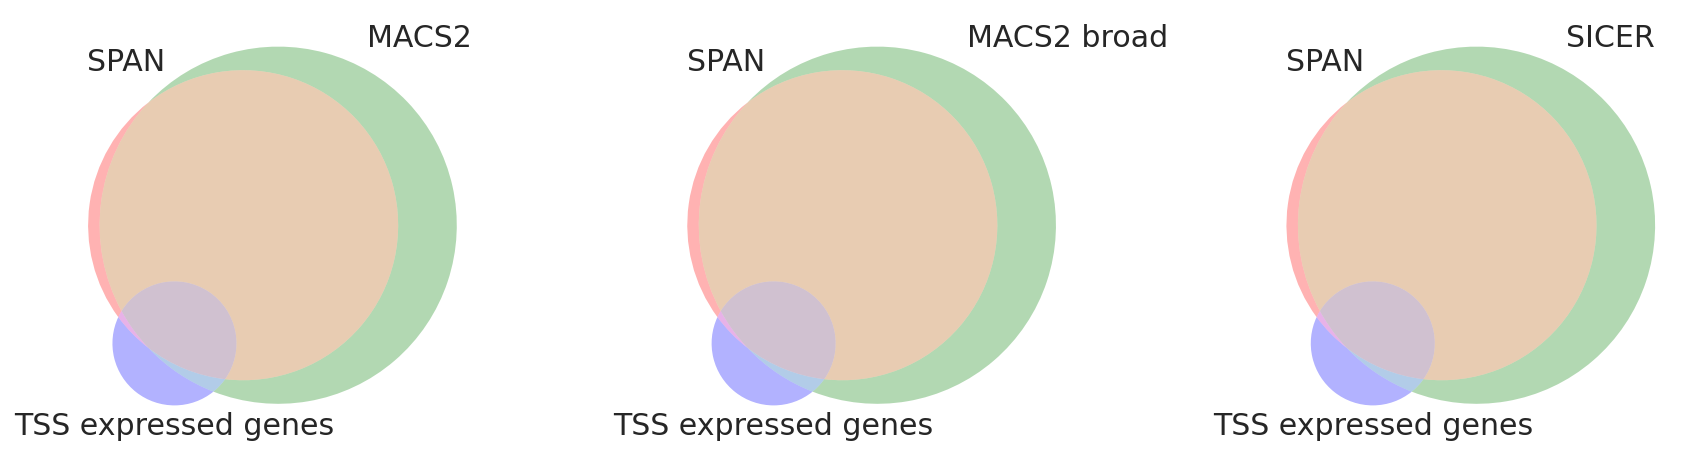

In [38]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(['GM12878'], ['rep1'])):
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    print(c, r)
    tss_file = sorted_file(EXPRESSION_TSS_BED[(c,r)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    tss_peaks = lines(tss_file)
    tss_length = int(bedl(tss_file).sum())

    print('Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_numbers=True, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {tss_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[(t['overlap_details'] == o).sum() for o in VENN3_SUBSETS],
                      'SPAN', tool, 'TSS expressed genes',
                      show_numbers=False, engineer=True)
    plt.tight_layout()
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (length)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'TSS expressed genes', show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

# Hg38 Recovered promoter fraction / Correct peak fraction

In [39]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_cpf_df = pd.DataFrame(
    columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    tss_file = sorted_file(EXPRESSION_TSS_BED[c, r])
    tss = lines(tss_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            benchmark_cpf_df.loc[len(benchmark_cpf_df)] = \
                (c, r, top, tss, peaks_file, peaks, peaks_overlap, tss_overlap, tool)

benchmark_cpf_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool
0,GM12878,rep1,1000.0,13836,/tmp/tmp8xh4i3je,1000,875,921,MACS2 broad
1,GM12878,rep1,2000.0,13836,/tmp/tmp8xh4i3je,2000,1727,1804,MACS2 broad
2,GM12878,rep1,3000.0,13836,/tmp/tmp8xh4i3je,3000,2551,2681,MACS2 broad
3,GM12878,rep1,4000.0,13836,/tmp/tmp8xh4i3je,4000,3372,3549,MACS2 broad
4,GM12878,rep1,5000.0,13836,/tmp/tmp8xh4i3je,5000,4131,4360,MACS2 broad
...,...,...,...,...,...,...,...,...,...
955,HepG2,rep2,11000.0,14951,/tmp/tmp7cx6chw0,11000,8425,7635,MACS2
956,HepG2,rep2,12000.0,14951,/tmp/tmp7cx6chw0,12000,8996,8026,MACS2
957,HepG2,rep2,13000.0,14951,/tmp/tmp7cx6chw0,13000,9463,8304,MACS2
958,HepG2,rep2,14000.0,14951,/tmp/tmp7cx6chw0,14000,9881,8531,MACS2


In [40]:
benchmark_cpf_df['p'] = (benchmark_cpf_df['pg'] + benchmark_cpf_df['gp']) / 2
benchmark_cpf_df['precision'] = [d(x, y) for x, y in zip(benchmark_cpf_df['pg'], benchmark_cpf_df['peaks'])]
benchmark_cpf_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_cpf_df['gp'], benchmark_cpf_df['genes'])]
benchmark_cpf_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_cpf_df['sensitivity'], benchmark_cpf_df['precision'])]
benchmark_cpf_df

,cell,replicate,top,genes,peaks_file,peaks,pg,gp,tool,p,precision,sensitivity,f1
0,GM12878,rep1,1000.0,13836,/tmp/tmp8xh4i3je,1000,875,921,MACS2 broad,898.0,0.875000,0.066565,0.123719
1,GM12878,rep1,2000.0,13836,/tmp/tmp8xh4i3je,2000,1727,1804,MACS2 broad,1765.5,0.863500,0.130385,0.226560
2,GM12878,rep1,3000.0,13836,/tmp/tmp8xh4i3je,3000,2551,2681,MACS2 broad,2616.0,0.850333,0.193770,0.315618
3,GM12878,rep1,4000.0,13836,/tmp/tmp8xh4i3je,4000,3372,3549,MACS2 broad,3460.5,0.843000,0.256505,0.393329
4,GM12878,rep1,5000.0,13836,/tmp/tmp8xh4i3je,5000,4131,4360,MACS2 broad,4245.5,0.826200,0.315120,0.456230
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,HepG2,rep2,11000.0,14951,/tmp/tmp7cx6chw0,11000,8425,7635,MACS2,8030.0,0.765909,0.510668,0.612772
956,HepG2,rep2,12000.0,14951,/tmp/tmp7cx6chw0,12000,8996,8026,MACS2,8511.0,0.749667,0.536820,0.625636
957,HepG2,rep2,13000.0,14951,/tmp/tmp7cx6chw0,13000,9463,8304,MACS2,8883.5,0.727923,0.555414,0.630074
958,HepG2,rep2,14000.0,14951,/tmp/tmp7cx6chw0,14000,9881,8531,MACS2,9206.0,0.705786,0.570597,0.631032


In [41]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [56]:
import plotly.graph_objects as go

def plot_top(benchmark_cpf_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_cpf_df[(benchmark_cpf_df['cell'] == c) &
                           (benchmark_cpf_df['replicate'] == r) &
                           (benchmark_cpf_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=PLOTLY_TOOLS_PALETTE[t],
            opacity=0.8,
        ))
        tools_legend_shown.add(t)

    # fig.update_xaxes(range=[-0.1, 1.1], title='Correct promoter fraction (sensitivity)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Recovered promoter fraction (precision)')
    fig.update_xaxes(title='Correct promoter fraction (sensitivity)')
    fig.update_yaxes(title='Recovered promoter fraction (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()


In [59]:
plot_top(benchmark_cpf_df[(benchmark_cpf_df['cell'] == 'GM12878') & (benchmark_cpf_df['replicate'] == 'rep1')])

In [60]:
plot_top(benchmark_cpf_df)

# Functional annotations

In [78]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

! rm -r {GSE26320_PATH_HG38}/summary_H3K4me3
! mkdir -p {GSE26320_PATH_HG38}/summary_H3K4me3

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{GSE26320_PATH_HG38}/summary_H3K4me3/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            ! cat {tf} >> "{GSE26320_PATH_HG38}/summary_H3K4me3/{filename}.bed_"

for f in os.listdir(GSE26320_PATH_HG38 + '/summary_H3K4me3'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{GSE26320_PATH_HG38}/summary_H3K4me3/{f}" | cut -f1-3> "{GSE26320_PATH_HG38}/summary_H3K4me3/{f_sorted}"
    ! rm "{GSE26320_PATH_HG38}/summary_H3K4me3/{f}"

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


# Coverage

In [61]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [63]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K4me3')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/85 [00:00<?, ?it/s]

,file,modification,cell,replicate
13,/home/jetbrains/data/2023_GSE26320/bw/GSM64638...,H3K4me3,HMEC,rep2
10,/home/jetbrains/data/2023_GSE26320/bw/GSM64640...,H3K4me3,HSMM,rep2
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64638...,H3K4me3,HMEC,rep1


  0%|          | 0/85 [00:00<?, ?it/s]

,file,modification,cell,replicate
11,/home/jetbrains/data/2023_GSE26320/bw/GSM64637...,Input,HepG2,rep1
10,/home/jetbrains/data/2023_GSE26320/bw/GSM64637...,Input,HepG2,rep2
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep2


In [64]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

In [65]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K4me3') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,modification,cell,replicate,name,position,length,type,coverage,total_coverage
2805308,H3K4me3,NHLF,rep2,SICER,chr3:172038600-172046399,7799,control,3150.0,6.894426e+08
796572,H3K4me3,HMEC,rep1,MACS2,chr11:62880362-62881566,1204,control,300.0,3.169744e+08
1579050,H3K4me3,K562,rep1,SICER,chr2:12604200-12606799,2599,treatment,2900.0,1.190659e+09
871360,H3K4me3,HMEC,rep1,SPAN - MACS2 broad,chr3:89179433-89180354,921,control,0.0,3.171045e+08
2765791,H3K4me3,NHLF,rep2,MACS2 broad,chr8:142776793-142778134,1341,control,814.0,6.897067e+08


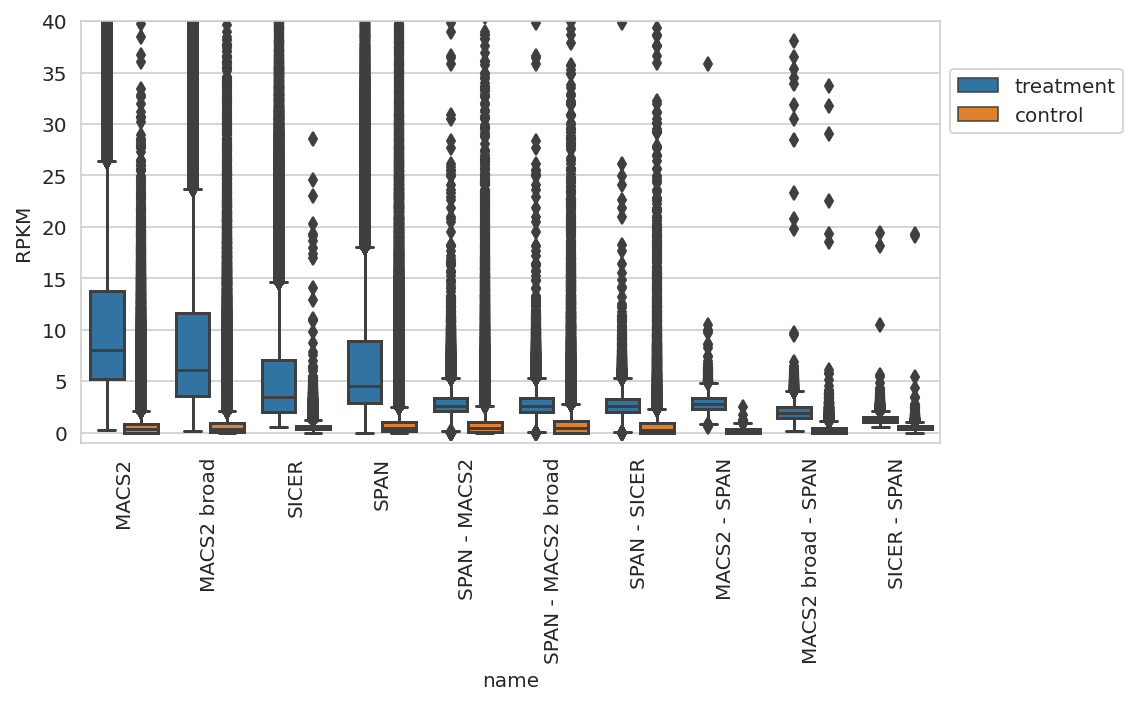

In [76]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(8, 5))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 40)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.81))
plt.tight_layout()
plt.show()